## Intentaré predecir 12 h en el futuro

In [1]:
# Common imports y set up de cada notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import statsmodels.api as sm
from datetime import datetime
import time
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator

# Para imprimir objetos grandes
#np.set_printoptions(threshold = np.inf)

# Para mantener los resultados constantes al ejecutar
np.random.seed(42) # Un random.seed constante

# Para graficar figuras bonitas
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rcParams["figure.figsize"] = (12,6.75)
mpl.rcParams["axes.grid"] = False


# Guardar/importar imágenes

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Guardar/importar datos
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

# Guardar datasets
DATASETS = os.path.join(PROJECT_ROOT_DIR, "datasets")
os.makedirs(DATASETS, exist_ok=True)

# Guardar modelos
MODELS = os.path.join(PROJECT_ROOT_DIR, "modelos")
os.makedirs(MODELS, exist_ok=True)

# Funciones 

In [2]:
def plot_real_vs_predicted(Y_real, Y_predicted, x_limits = (0,-1), savefig = False,
                           figname = "figure", formato = "png"):
    
    name = figname + "." + formato
    
    plt.figure(figsize = (12.8,7.2))
    
    y_limits = (np.min([Y_real.min(), Y_predicted.min()]), np.max([Y_real.max(), Y_predicted.max()]))
    plt.ylim(y_limits)
    #y_limits = (Y_real.min(), Y_real.max())
    #plt.ylim(y_limits)
    
    plt.plot(Y_real[x_limits[0]:x_limits[-1]], color = "black", linestyle = "-", linewidth=2, label="Real"), # color = "darkorange",
    plt.plot(Y_predicted[x_limits[0]:x_limits[-1]], "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize = (12, 6.75))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("epoch")
    plt.ylabel("mse")
    plt.grid(True)
    plt.show() 

def plot_train_vs_val(train_errors, val_errors, savefig = False, 
                            figname = "figure", formato = "png"):
        
    name = figname + "." + formato
    
    plt.figure(figsize = (12,6.75))

    y_limits = (np.min([train_errors.min(), val_errors.min()]), np.max([train_errors.max(), val_errors.max()]))
    plt.ylim(y_limits)
        
    plt.plot(train_errors,  "b-.", linewidth=2, label="Training"), # color = "darkorange",
    plt.plot(val_errors, "r-.", linewidth=2, label="Validation")
    plt.legend(loc = 1, fontsize=17)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("mse", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    if savefig == True:
        plt.tight_layout()
        plt.savefig(os.path.join(IMAGES_PATH, name), 
                    format = formato, dpi = 200)
    
    plt.show() 
    
    
def plot_hours(real, predicted, targets = 1, bloques = 12):
    
    Y_real = []
    Y_predicted = []
    
    a = 0
    for i in range(0, targets*bloques, bloques):
        
        Y_real.extend(real[i])
        Y_predicted.extend(predicted[i])
         
    plt.figure(figsize = (12, 6.75))
    plt.plot(Y_real, color = "black", linestyle = "-", linewidth=2, label="Real")
    plt.plot(Y_predicted,  "r.-", linewidth=2, label="Predicted")
    plt.legend(loc = 1, fontsize=14)    
    plt.xlabel("Time (1 h)", fontsize=14) 
    plt.ylabel("Consumption (normalized)", fontsize=14)      
    plt.grid(which='major', axis='both', color='grey', linestyle='--', linewidth=0.75)
    
    plt.show()

# Importo los datos

In [3]:
df_train = pd.read_csv(os.path.join(DATASETS, "df_train.csv"))
df_test = pd.read_csv(os.path.join(DATASETS, "df_test.csv"))

formato = '%Y-%m-%d %H'

df_train['Datetime'] = pd.to_datetime(df_train["Datetime"], format=formato, utc = True)
df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))
df_train.drop(["Datetime"], axis = "columns", inplace = True)

df_test['Datetime'] = pd.to_datetime(df_test["Datetime"], format=formato, utc = True)
df_test = df_test.set_index(pd.DatetimeIndex(df_test['Datetime']))
df_test.drop(["Datetime"], axis = "columns", inplace = True)

useful_features = df_train.columns.to_list()
print(df_train.shape, df_train.columns, "\n")
print(df_test.shape, df_test.columns, "\n")
print(df_train.index.min(), df_train.index.max(), df_test.index.min(), df_test.index.max())

(28051, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y + 11',
       'y + 12', 'y + 13', 'y + 14', 'y + 15', 'y + 16', 'y + 17', 'y + 18',
       'y + 19', 'y + 20', 'y + 21', 'y + 22', 'y + 23', 'y + 24'],
      dtype='object') 

(7013, 38) Index(['total_generation', 'money_spent', 'hour',
       'generation_hydro_pumped_storage_consumption', 'price_actual',
       'generation_solar', 'generation_fossil_gas', 'x14_01d', 'x12_01n',
       'generation_hydro_water_reservoir', 'x14_01n', 'humidity_Va',
       'humidity_Ba', 'Consumo_MW', 'y + 1', 'y + 2', 'y + 3', 'y + 4',
       'y + 5', 'y + 6', 'y + 7', 'y + 8', 'y + 9', 'y + 10', 'y +

# Preparación de los datasets

In [4]:
# Selecciono las columnas para multi step forecasting

df_train = df_train.iloc[:,:-12].dropna() #todas las columnas, de y + 1 a y + 12
df_test = df_test.iloc[:,:-12].dropna()
df_train.iloc[:,:]

,total_generation,money_spent,hour,generation_hydro_pumped_storage_consumption,price_actual,generation_solar,generation_fossil_gas,x14_01d,x12_01n,generation_hydro_water_reservoir,...,y + 3,y + 4,y + 5,y + 6,y + 7,y + 8,y + 9,y + 10,y + 11,y + 12
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,28251.0,1847897.91,23,863.0,65.41,49.0,4844.0,0.0,1.0,1899.0,...,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0
2015-01-01 00:00:00+00:00,27818.0,1805944.56,0,920.0,64.92,50.0,5196.0,0.0,1.0,1658.0,...,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0
2015-01-01 01:00:00+00:00,26796.0,1727806.08,1,1164.0,64.48,50.0,4857.0,0.0,1.0,1371.0,...,19905.0,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,24672.0
2015-01-01 02:00:00+00:00,25223.0,1496228.36,2,1503.0,59.32,50.0,4314.0,0.0,1.0,779.0,...,20010.0,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,24672.0,23528.0
2015-01-01 03:00:00+00:00,24620.0,1379704.80,3,1826.0,56.04,42.0,4130.0,0.0,1.0,720.0,...,20377.0,20094.0,20637.0,22250.0,23547.0,24133.0,24713.0,24672.0,23528.0,23118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14 01:00:00+00:00,27763.0,1219350.96,1,1390.0,43.92,15.0,3753.0,0.0,1.0,4098.0,...,24679.0,27668.0,31191.0,33771.0,35066.0,35567.0,35680.0,35676.0,35427.0,34230.0
2018-03-14 02:00:00+00:00,27710.0,1188759.00,2,1318.0,42.90,14.0,3729.0,0.0,1.0,4139.0,...,27668.0,31191.0,33771.0,35066.0,35567.0,35680.0,35676.0,35427.0,34230.0,33636.0
2018-03-14 03:00:00+00:00,28320.0,1208414.40,3,1627.0,42.67,15.0,3997.0,0.0,1.0,4256.0,...,31191.0,33771.0,35066.0,35567.0,35680.0,35676.0,35427.0,34230.0,33636.0,33116.0


In [5]:
# Selecciono las columnas

X_Y_train = df_train.to_numpy()
X_Y_test = df_test.to_numpy()
X_test = X_Y_test[:,:-12]
Y_test = X_Y_test[:,-12:]


# Hago la división en train y val

from sklearn.model_selection import train_test_split, TimeSeriesSplit

# Hacer train_test_split con shuffle = False y random_state = cte sirve para dividir time series

X_train, X_val, Y_train, Y_val = train_test_split(X_Y_train[:,:-12], X_Y_train[:,-12:],
                                                  test_size = 0.25, random_state = 42, shuffle = False)

In [6]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((21029, 14), (21029, 12), (7001, 14), (7001, 12))

In [7]:
# Escalo la data a un rango [0, 1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_Y_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train)], axis = 1)
#X_Y_train = np.concatenate([X_train, np.expand_dims(Y_train, axis=1)], axis = 1)
X_Y_train = scaler.fit_transform(X_Y_train)

X_Y_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(Y_val)], axis = 1)
#X_Y_val = np.concatenate([X_val, np.expand_dims(Y_val, axis=1)], axis = 1)
X_Y_val = scaler.transform(X_Y_val)

X_Y_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(Y_test)], axis = 1)
#X_Y_test = np.concatenate([X_test, np.expand_dims(Y_test, axis=1)], axis = 1)
X_Y_test = scaler.transform(X_Y_test)

In [8]:
X_Y_train[:,:-12].shape, X_Y_train[:,-12:].shape, X_Y_val[:,:-12].shape, X_Y_val[:,-12:].shape, X_Y_test[:,:-12].shape, X_Y_test[:,-12:].shape

((21029, 14), (21029, 12), (7010, 14), (7010, 12), (7001, 14), (7001, 12))

In [9]:
# Lo convierto en un problema de ML

win_len = 24            # Intento predecir el consumo durante las próximas 24 h, con 24 h de antelación
tamaño_del_batch = 64
number_of_features = 14
horizonte = 12
sep = 1

# series

train_ts_generator = TimeseriesGenerator(X_Y_train[:,:-12], X_Y_train[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)

val_ts_generator = TimeseriesGenerator(X_Y_val[:,:-12], X_Y_val[:,-12:], length = win_len, sampling_rate = 1,
                                       batch_size = tamaño_del_batch, stride = sep)

test_ts_generator = TimeseriesGenerator(X_Y_test[:,:-12], X_Y_test[:,-12:], length = win_len, sampling_rate = 1,
                                         batch_size = tamaño_del_batch, stride = sep)


# length es el tamaño de la ventana
# sampling_rate es cada cuánto consideramos un dato (1 para datos continuos)
# stride es la separación entre una muestra de train y la siguiente 


print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(train_ts_generator[0][0].shape, train_ts_generator[0][1].shape)

(21029, 14) (21029, 12) (7010, 14) (7010, 12)
(64, 24, 14) (64, 12)


In [10]:
print("muestra de feature vector:", "\n", train_ts_generator[0][0][0].shape, "\n")
print("muestra de target  vector:", "\n", train_ts_generator[0][-1][0].shape)

muestra de feature vector: 
 (24, 14) 

muestra de target  vector: 
 (12,)


# Modelos de base & tabla de errores

In [11]:
# creo un dataframe para guardar los errores

from sklearn.metrics import mean_squared_error

errores_df = pd.DataFrame()

#naive_train_errors = list()
#naive_val_errors = list()
#naive_test_errors = list()
#
#for i in range(24, len(naive_train.index)):
#    actual = naive_train.iloc[i,:-24].to_numpy()
#    predicted = naive_train.iloc[i,-24:].to_numpy()
#    naive_train_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_val.index)):
#    actual = naive_val.iloc[i,:-24].to_numpy()
#    predicted = naive_val.iloc[i,-24:].to_numpy()
#    naive_val_errors.append(mean_squared_error(actual, predicted))
#for i in range(24, len(naive_test.index)):
#    actual = naive_test.iloc[i,:-24].to_numpy()
#    predicted = naive_test.iloc[i,-24:].to_numpy()
#    naive_test_errors.append(mean_squared_error(actual, predicted))
#
#naive_train_errors = np.array(naive_train_errors)
#naive_val_errors   = np.array(naive_val_errors)
#naive_test_errors  = np.array(naive_test_errors)

# El error total del set es la suma (o la media, aún por decidir) de los mse de cada predicción de 24 h

errores_df.loc["naive_1h", "train mse"] = np.nan
errores_df.loc["naive_1h", "val mse"] = np.nan

errores_df.loc["naive_1h", "delta errores"] = np.nan
errores_df.loc["naive_1h", "n params"] = 0
errores_df.loc["naive_1h", "training time (s)"] = np.nan
errores_df.loc["naive_1h", "training prediction time (s)"] = np.nan
errores_df.loc["naive_1h", "validation prediction time (s)"] = np.nan

pd.options.display.float_format = '{:.2e}'.format
#pd.options.display.float_format = '{:.7f}'.format
#pd.reset_option("all")
errores_df.sort_values(by = ["val mse"])

,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


### RNN 1

In [12]:
np.random.seed(42)
tf.random.set_seed(42)


rnn_1 = keras.models.Sequential([
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features],
                           return_sequences = True),
    keras.layers.SimpleRNN(24, input_shape = [win_len, number_of_features]),
    keras.layers.Dense(horizonte)                                                      
])

checkpoint_rnn_1 = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "rnn_multistep.h5"), save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience = 10)

rnn_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_rnn_1 = rnn_1.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint_rnn_1])

Epoch 1/50
329/329 [==============================] - 5s 14ms/step - loss: 0.0477 - val_loss: 0.0367
Epoch 2/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0270 - val_loss: 0.0230
Epoch 3/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0195 - val_loss: 0.0170
Epoch 4/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0159 - val_loss: 0.0146
Epoch 5/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0142 - val_loss: 0.0137
Epoch 6/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 7/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 8/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0117 - val_loss: 0.0123
Epoch 9/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 10/50
329/329 [==============================] - 4s 13ms/step - loss: 0.0106 - val_lo

In [13]:
# Recuperar el modelo si queremos seguir entrenando
# rnn_1 = keras.models.load_model(os.path.join(MODELS, "rnn_1.h5")) recuperar el mejor modelo

In [14]:
rnn_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 24)            936       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24)                1176      
_________________________________________________________________
dense (Dense)                (None, 12)                300       
Total params: 2,412
Trainable params: 2,412
Non-trainable params: 0
_________________________________________________________________


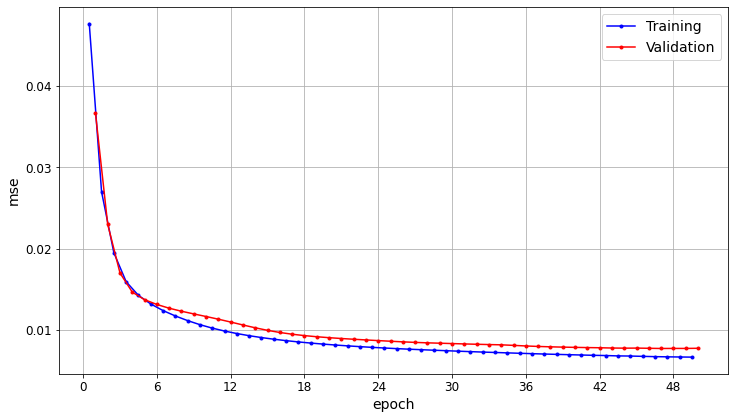

In [15]:
history_rnn_1_df = pd.DataFrame(history_rnn_1.history)


plot_learning_curves(history_rnn_1_df["loss"], history_rnn_1_df["val_loss"])

### Visualizo el training set y el validation set

In [16]:
Y_train_rnn_1  = rnn_1.predict(train_ts_generator)
df_train_rnn_1 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_rnn_1)], axis = 1)

Y_val_rnn_1    = rnn_1.predict(val_ts_generator)
df_val_rnn_1   = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_rnn_1)], axis = 1)

In [17]:
errores_df.loc["rnn_1", "train mse"]     = rnn_1.evaluate(train_ts_generator)
errores_df.loc["rnn_1", "val mse"]       = rnn_1.evaluate(val_ts_generator)
errores_df.loc["rnn_1", "n params"]      = rnn_1.count_params()
errores_df.loc["rnn_1", "delta errores"] = np.abs(errores_df.loc["rnn_1", "train mse"]-errores_df.loc["rnn_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 1s 5ms/step - loss: 0.0077


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
rnn_1,7.80e-03,7.74e-03,6.39e-05,2.41e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


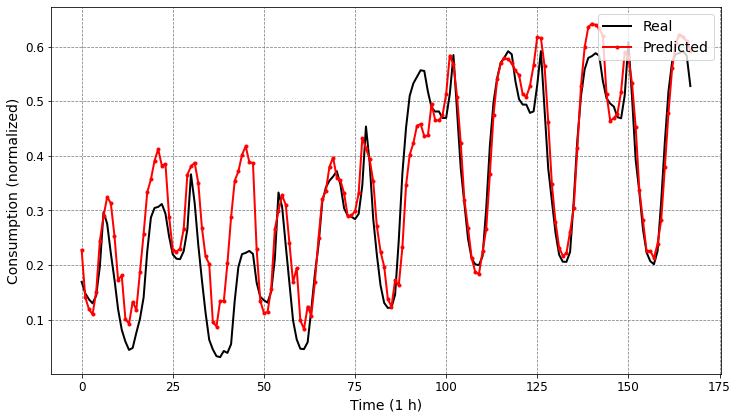

In [18]:
plot_hours(df_train_rnn_1.iloc[-1000:,:-12].to_numpy(), df_train_rnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

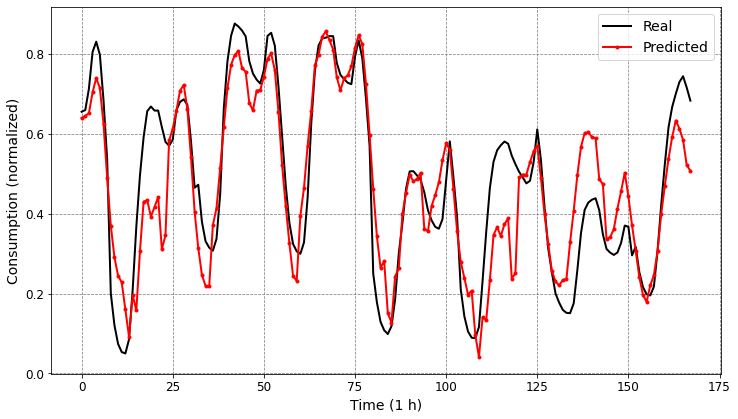

In [19]:
plot_hours(df_val_rnn_1.iloc[-1000:,:-12].to_numpy(), df_val_rnn_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

### LSTM 1

In [20]:
np.random.seed(42)
tf.random.set_seed(42)


lstm_1 = keras.models.Sequential([
        keras.layers.LSTM(48, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(24, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features], return_sequences = True),
        keras.layers.LSTM(12, input_shape=[None, number_of_features],),# return_sequences = True),
        #keras.layers.TimeDistributed(keras.layers.Dense(24), input_shape=[win_len, number_of_features])
        keras.layers.Dense(horizonte)                                                      
])

checkpoint_lstm_1 = keras.callbacks.ModelCheckpoint(os.path.join(MODELS, "lstm_multistep.h5"), save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience = 5)

lstm_1.compile(loss = "mse", optimizer = "adam") # metrics = ["mse"])
                      
history_lstm_1 = lstm_1.fit(train_ts_generator, epochs = 50, validation_data = val_ts_generator, shuffle = False,
                         callbacks = [early_stopping, checkpoint_lstm_1])

Epoch 1/50
329/329 [==============================] - 37s 112ms/step - loss: 0.0497 - val_loss: 0.0273
Epoch 2/50
329/329 [==============================] - 35s 106ms/step - loss: 0.0223 - val_loss: 0.0201
Epoch 3/50
329/329 [==============================] - 34s 104ms/step - loss: 0.0185 - val_loss: 0.0176
Epoch 4/50
329/329 [==============================] - 34s 104ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 5/50
329/329 [==============================] - 34s 105ms/step - loss: 0.0137 - val_loss: 0.0145
Epoch 6/50
329/329 [==============================] - 34s 104ms/step - loss: 0.0122 - val_loss: 0.0134
Epoch 7/50
329/329 [==============================] - 34s 105ms/step - loss: 0.0111 - val_loss: 0.0124
Epoch 8/50
329/329 [==============================] - 34s 104ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 9/50
329/329 [==============================] - 34s 105ms/step - loss: 0.0096 - val_loss: 0.0108
Epoch 10/50
329/329 [==============================] - 35s 107ms/step - l

In [21]:
lstm_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 48)          12096     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 24)          7008      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 12)          1776      
_________________________________________________________________
lstm_3 (LSTM)                (None, 12)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
Total params: 22,236
Trainable params: 22,236
Non-trainable params: 0
_________________________________________________________________


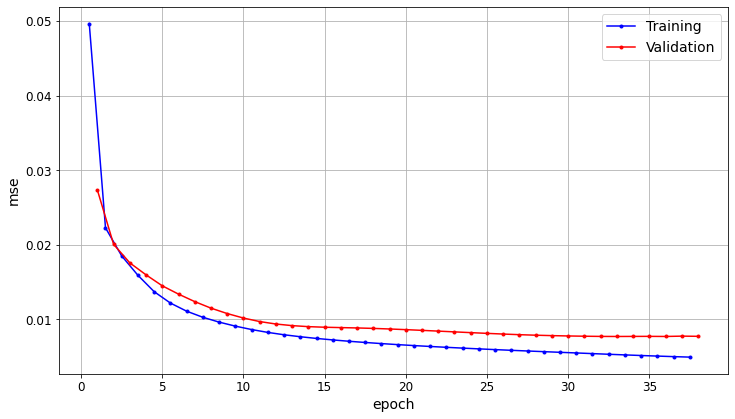

In [22]:
history_lstm_1_df = pd.DataFrame(history_lstm_1.history)


plot_learning_curves(history_lstm_1_df["loss"], history_lstm_1_df["val_loss"])

### Visualizo el training set y el validation set

In [23]:
Y_train_lstm_1  = lstm_1.predict(train_ts_generator)
df_train_lstm_1 = pd.concat([pd.DataFrame(X_Y_train[win_len:,-12:]), pd.DataFrame(Y_train_lstm_1)], axis = 1)

Y_val_lstm_1    = lstm_1.predict(val_ts_generator)
df_val_lstm_1   = pd.concat([pd.DataFrame(X_Y_val[win_len:,-12:]), pd.DataFrame(Y_val_lstm_1)], axis = 1)

In [24]:
errores_df.loc["lstm_1", "train mse"]     = lstm_1.evaluate(train_ts_generator)
errores_df.loc["lstm_1", "val mse"]       = lstm_1.evaluate(val_ts_generator)
errores_df.loc["lstm_1", "n params"]      = lstm_1.count_params()
errores_df.loc["lstm_1", "delta errores"] = np.abs(errores_df.loc["lstm_1", "train mse"]-errores_df.loc["lstm_1", "val mse"])

errores_df.sort_values(by = ["val mse"])

110/110 [==============================] - 4s 37ms/step - loss: 0.0077


,train mse,val mse,delta errores,n params,training time (s),training prediction time (s),validation prediction time (s)
lstm_1,6.63e-03,7.73e-03,1.10e-03,2.22e+04,nan,nan,nan
rnn_1,7.80e-03,7.74e-03,6.39e-05,2.41e+03,nan,nan,nan
naive_1h,nan,nan,nan,0.00e+00,nan,nan,nan


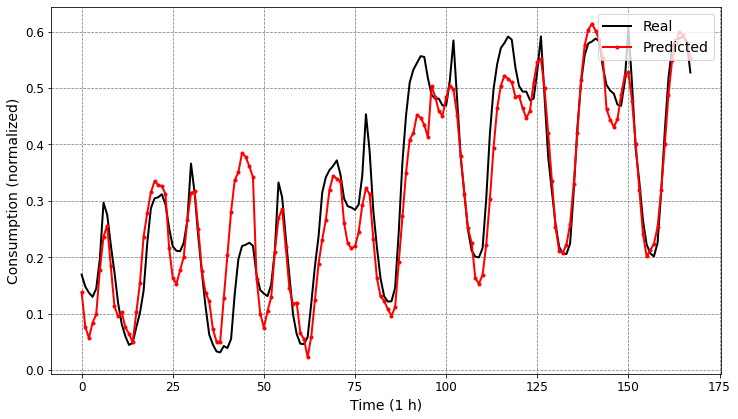

In [25]:
plot_hours(df_train_lstm_1.iloc[-1000:,:-12].to_numpy(), df_train_lstm_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)

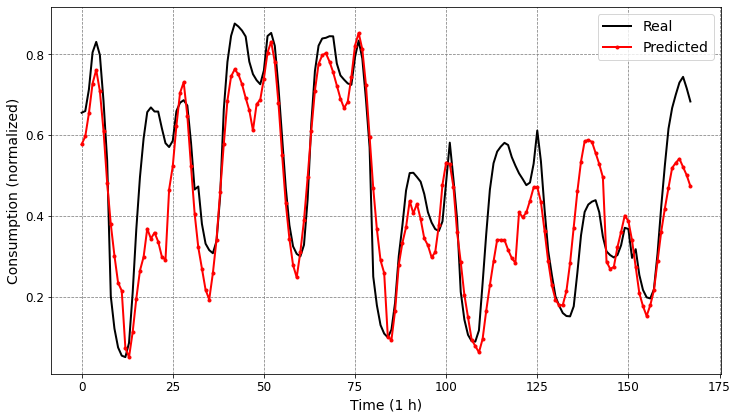

In [26]:
plot_hours(df_val_lstm_1.iloc[-1000:,:-12].to_numpy(), df_val_lstm_1.iloc[-1000:,-12:].to_numpy(),
           targets = 14)